In [1]:
import glob
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns

# Auxiliary function

### Subset a dataset by time
The following function $\mathtt{subset\_dataset}$ loads a NetCDF dataset and extracts the data between two time instants $\mathtt{time\_start}$ and $\mathtt{time\_end}$ in format HH:MM.  

In [2]:
def subset_dataset(nc_file, time_start, time_end, ref_day=None, time_var="time"):

    ds = xr.open_dataset(nc_file)
    tvals = ds[time_var].values

    # Detect type (strings and numeric types, e.g., seconds since midnight, are also handled)
    if np.issubdtype(tvals.dtype, np.datetime64):
        times = pd.to_datetime(tvals)
    elif np.issubdtype(tvals.dtype, np.number):
        if ref_day is None:
            ref_day = pd.to_datetime("today").strftime("%Y-%m-%d")
        times = pd.to_datetime(ref_day) + pd.to_timedelta(tvals, unit="s")
    else:
        times = pd.to_datetime(tvals)

    # Handle time_start/time_end strings like HH:MM or HH:MM:SS
    if isinstance(time_start, str) and len(time_start) <= 8:
        date_str = times[0].strftime("%Y-%m-%d")
        time_start = pd.to_datetime(f"{date_str}T{time_start}")
    else:
        time_start = pd.to_datetime(time_start)

    if isinstance(time_end, str) and len(time_end) <= 8:
        date_str = times[0].strftime("%Y-%m-%d")
        time_end = pd.to_datetime(f"{date_str}T{time_end}")
    else:
        time_end = pd.to_datetime(time_end)

    # Locate nearest time indices for subsetting
    idx_start = np.argmin(np.abs(times - time_start))
    idx_end = np.argmin(np.abs(times - time_end)) + 1

    return ds.isel({time_var: slice(idx_start, idx_end)})

### Load datasets

In [3]:
time_start, time_end = "18:28", "18:43"

# --- IN-SITU MEASUREMENTS TURBULENCE (25 Hz) ---

file_path = "/Users/m219063/work/data/orcestra/"
turb = subset_dataset(
    file_path
    + "MAESTRO_ORCESTRA_ATR_TURBULENCE_CALIBRATED_RF21_as240043_20240903_RF21_A3_v0.nc",
    time_start,
    time_end,
)
time, T = turb.time.values, turb.T.values - 273.15

# The above file includes calibrated time series over the ascent segment A3 (other flight segments available here: https://thredds-x.ipsl.fr/thredds/catalog/MAESTRO/INSITU/AIRCRAFT/ATR/TURBULENCE/DATA/LEG_Time_Series/RF_21/catalog.html).
# If you want to include time intervals beyond this segment, it is better to use the following dataset:
# turb = subset_dataset('MAESTRO-2024_SAFIRE-ATR42_SAFIRE_FAST_25HZ_20240903_as240043_L2_V1.nc', time_start, time_end)
# time, T = turb.time.values, turb.TFAST1.values


# --- IN-SITU MEASUREMENTS MICROPHYSICS (SAMPLING FREQUENCY 1 Hz) ---

micro = subset_dataset(
    file_path + "MAESTRO_09032024_RF21_Cloud_in-situ_COMPOSITE_L3_v5.nc",
    time_start,
    time_end,
)
LWC, IWC = micro.lwc.values, micro.iwc.values


# --- RaLi DATASET AND VARIABLES ---

file = glob.glob(
    file_path + "target_classification_rali_MAESTRO_20240903_F43_nshots_100_v1.0.nc"
)[0]
rali = subset_dataset(file, time_start, time_end)

# RaLi time: convert from seconds since midnight to full datetime using the date YYYY-MM-DD from the first measurement
# of the TURBULENCE dataset
date_str = pd.to_datetime(time)[0].strftime("%Y-%m-%d")
t_seconds = rali.time.values
rali_time_dt = pd.to_datetime(date_str) + pd.to_timedelta(t_seconds, unit="s")

# Creation of a masked array of reflectivity corrected for two-way gaseous attenuation along the outgoing and return paths of the radar beam.
# Only valid cloud or precipitation points are retained as well as interpolated values where data were missing or reconstructed.
rasta_Z_interpolated_clean = np.ma.array(
    rali.rasta_Z_interpolated + rali.rasta_gaseous_twowayatt,
    mask=(rali.rasta_flag != 1)
    & (rali.rasta_flag != 2)
    & (rali.rasta_flag_Z_interpolated != 2)
    & (rali.rasta_flag_Z_interpolated != 3),
)


# --- DROPSONDE CIRCLES

# Find the closest (in time) dropsonde circle
ds_circles = xr.open_dataset(
    "ipfs://bafybeihfqxfckruepjhrkafaz6xg5a4sepx6ahhv4zds4b3hnfiyj35c5i", engine="zarr"
)
circle = ds_circles.isel(
    circle=np.abs(
        (
            pd.to_datetime(ds_circles["circle_time"].values) - pd.Timestamp(time[0])
        ).total_seconds()
    ).argmin()
)

### Plot variables as a function of altitude

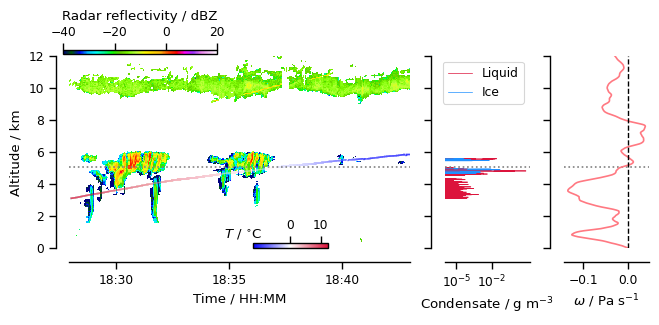

In [ ]:
cw = 190 / 25.4

# fig,ax = plt.subplots(ncols=3
fig, ax = plt.subplots(
    1, 3, sharey=True, figsize=(cw, cw / 3), gridspec_kw={"width_ratios": [4, 1, 1]}
)

sns.set_context("paper")

### PANEL REFLECTIVITY AND AIRCRAFT ALTITUDE COLORED BY T

# Radar reflectivity
im = ax[0].pcolormesh(
    rali_time_dt,
    rali.height_2D.values.T,
    rasta_Z_interpolated_clean.T,
    vmin=-40,
    vmax=20,
    cmap="gist_ncar",
)

# Colorbar reflectivity
cax = inset_axes(ax[0], width="45%", height="2%", loc="upper left", borderpad=-0.5)
cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.ax.xaxis.set_ticks_position("top")
cbar.ax.xaxis.set_label_position("top")
cbar.set_label("Radar reflectivity / dBZ")

# Aicraft altitude colored by temperature
points = np.array([mdates.date2num(time), turb.ALTITUDE.values / 1000.0]).T.reshape(
    -1, 1, 2
)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
cmap = mcolors.LinearSegmentedColormap.from_list(
    "temp_cmap", ["blue", "white", "crimson"]
)
norm = mcolors.TwoSlopeNorm(vmin=T.min(), vcenter=0, vmax=T.max())
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(T)
lc.set_linewidth(1)
ax[0].add_collection(lc)

# Colorbar temperature
cax_temp = fig.add_axes([0.37, 0.11, 0.1, 0.02])
cbar_temp = fig.colorbar(lc, cax=cax_temp, orientation="horizontal", location="top")

# Set axis limits and labels
date_format = mdates.DateFormatter("%H:%M")  # date in HH:MM format
ax[0].xaxis.set_major_formatter(date_format)
ax[0].set_xlabel("Time / HH:MM")
ax[0].set_ylim(0, 12)
ax[0].set_ylabel("Altitude / km")
ax[0].annotate("$T$ / $^{\\circ}$C", (0.3, 0.35), xycoords="figure fraction")

### PANEL CONDENSATE CONTENT
ax[1].plot(LWC, micro.altitude.values / 1e3, linewidth=0.5, c="crimson", label="Liquid")
ax[1].plot(IWC, micro.altitude.values / 1e3, linewidth=0.5, c="dodgerblue", label="Ice")
ax[1].set_xlabel("Condensate / g m$^{-3}$")
ax[1].set_xscale("log")
ax[1].legend()
ax[1].set_xticks([1.0e-5, 1.0e-2])

# add 0 degC lines
z0 = (turb.ALTITUDE.where(turb.T < 273.15, drop=True).min()).values / 1000.0
ax[0].axhline(z0, ls=":", c="grey")
ax[1].axhline(z0, ls=":", c="grey")
ax[2].axhline(z0, ls=":", c="grey")

### PANEL OMEGA FROM DROPSONDE CIRCLES
ax[2].plot(circle.omega.values, circle.altitude.values / 1000.0, color="#FF7982")
ax[2].axvline(0, lw=1.0, ls="--", c="k")
ax[2].set_xlabel("$\\omega$ / Pa s$^{-1}$")

sns.despine(offset=10, ax=ax[0])
sns.despine(offset=10, ax=ax[1])
sns.despine(offset=10, ax=ax[2])

fig.savefig("Spiral_ascent_0903.png", bbox_inches="tight", dpi=600)

### Plot (former version, without lat-lon labels)

Text(0.5, 0, 'Time / HH:MM')

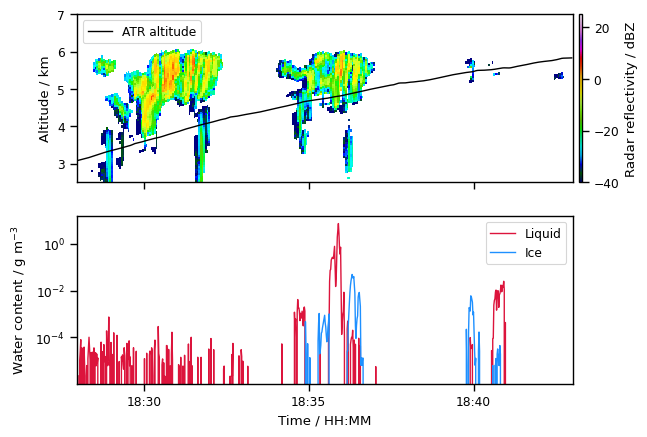

In [6]:
fig, ax = plt.subplots(nrows=2, sharex=True)

# Radar reflectivity
im = ax[0].pcolormesh(
    rali_time_dt,
    rali.height_2D.values.T,
    rasta_Z_interpolated_clean.T,
    vmin=-40,
    vmax=25,
    cmap="gist_ncar",
)
ax[0].plot(rali_time_dt, rali.altitude.values, c="k", linewidth=1, label="ATR altitude")
ax[0].set_ylim(2.5, 7)
ax[0].set_ylabel("Altitude / km")
pos = ax[0].get_position()
cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.005, pos.height])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Radar reflectivity / dBZ")
ax[0].legend(loc="upper left")

# Water content
ax[1].plot(
    pd.to_datetime(micro.time.values), LWC, linewidth=1, c="crimson", label="Liquid"
)
ax[1].plot(
    pd.to_datetime(micro.time.values), IWC, linewidth=1, c="dodgerblue", label="Ice"
)
ax[1].set_ylabel("Water content / g m$^{-3}$")
ax[1].set_yscale("log")
ax[1].legend()
# ax[0].plot(time, turb.T.values)

# Date in HH:MM format
date_format = mdates.DateFormatter("%H:%M")
ax[-1].xaxis.set_major_formatter(date_format)
ax[-1].set_xlabel("Time / HH:MM")